In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pickle
from keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression

**Load the training dataset**

In [194]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    
for i in range(1, 6):
    dict = unpickle('data_batch_'+str(i))
    x_data = dict[b'data']
    y_data = np.array(dict[b'labels'])
    if i == 1:
        x_training = x_data
        y_training = y_data
    else:
        x_training = np.concatenate((x_training, x_data))
        y_training = np.concatenate((y_training, y_data))
        
dict = unpickle('test_batch')
x_testing = dict[b'data'] 
y_testing = np.array(dict[b'labels'])

x_training.shape, y_training.shape, x_testing.shape, y_testing.shape

((50000, 3072), (50000,), (10000, 3072), (10000,))

The image data needs to be normalised, the pixel values will range from 0 to 1.

In [251]:
x_training =x_training/255
y_training = y_training
x_testing = x_testing/255
y_testing = y_testing

**Exploratory Data Analysis:**

In [216]:
x_train_reshaped = x_training[0].reshape(3,32,32).transpose([ 1, 2, 0])
x_train_reshaped.shape

(32, 32, 3)

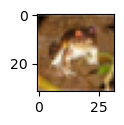

In [217]:
plt.figure(figsize = (1, 1)) 
plt.imshow(x_train_reshaped)

Each row of the sample CIFAR-10 Dataset is labelled according to the object in the picture, so classes will be defined as follows:

In [218]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

y_training[0,:] returns 6, class_names[6] = "Frog"

y_training[1,:] returns 9, class_names[9] = "Truck"

Text(0.5, 0, 'Deer')

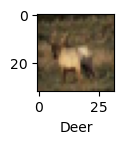

In [219]:
plt.figure(figsize = (1, 1))
plt.imshow(x_training[3].reshape(3,32,32).transpose([ 1, 2, 0]))
plt.xlabel(class_names[y_training[3]])

The unpickled data from the batch files is already flattened, so there is no need to reshape the data from 32x32x3 to 3072. A dataframe will be created to show the observations and features of the training set.

In [220]:
feature_columns = ['Pixel_' + str(i) for i in range((x_training).shape[1])]
x_train_df = pd.DataFrame(x_training, columns = feature_columns)
x_train_df['Label'] = y_training
x_train_df.head()

,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,...,Pixel_3063,Pixel_3064,Pixel_3065,Pixel_3066,Pixel_3067,Pixel_3068,Pixel_3069,Pixel_3070,Pixel_3071,Label
0,0.231373,0.168627,0.196078,0.266667,0.384314,0.466667,0.545098,0.568627,0.584314,0.584314,...,0.227451,0.254902,0.231373,0.180392,0.223529,0.407843,0.549020,0.329412,0.282353,6
1,0.603922,0.494118,0.411765,0.400000,0.490196,0.607843,0.674510,0.705882,0.556863,0.435294,...,0.164706,0.262745,0.396078,0.478431,0.521569,0.533333,0.545098,0.556863,0.564706,9
2,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.325490,0.313725,0.270588,0.258824,0.282353,0.309804,0.325490,0.325490,0.329412,9
3,0.109804,0.145098,0.149020,0.164706,0.172549,0.156863,0.156863,0.094118,0.125490,0.168627,...,0.152941,0.231373,0.164706,0.172549,0.188235,0.149020,0.109804,0.145098,0.180392,4
4,0.666667,0.658824,0.694118,0.717647,0.709804,0.694118,0.709804,0.721569,0.741176,0.741176,...,0.345098,0.333333,0.321569,0.325490,0.309804,0.305882,0.321569,0.305882,0.313725,1


**Principle Component Analysis**

The image data (training and test sets) have to be reduced to 658, 217 and 99 features with the aim of improving training and computational efficiecy and model accuracy. A significant amount of the explained variance has to be captured to ensure that the model will be able to execute the classification. 

In [222]:
# Reduce image dataset to 658 features
pca_658 = PCA(n_components = 658)
pca_658_data = pca_658.fit_transform(x_train_df.iloc[:,:-1])
pca_columns = ['PC_' + str(i+1) for i in range((pca_658_data).shape[1])]
x_train_pca_658 = pd.DataFrame(data = pca_658_data, columns = pca_columns)
x_train_pca_658['Label'] = y_training
x_train_pca_658.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_650,PC_651,PC_652,PC_653,PC_654,PC_655,PC_656,PC_657,PC_658,Label
0,-6.401018,2.729039,1.501711,-2.953333,-4.452582,0.647150,0.568989,0.092877,3.451771,1.168442,...,-0.038987,0.003489,0.104522,0.049940,-0.028230,0.045721,-0.042537,-0.027161,-0.168442,6
1,0.829783,-0.949943,6.003753,1.504931,-1.368500,1.225687,0.606882,-0.523086,2.584150,2.565564,...,0.003065,0.146165,-0.170464,-0.231176,0.073827,-0.001975,0.071112,-0.040846,-0.056223,9
2,7.730200,-11.522102,-2.753621,2.333595,-1.584409,-2.272213,-0.610438,-1.361358,-0.730908,-1.125914,...,0.074948,-0.037555,-0.007621,0.044770,-0.080896,0.009134,-0.062690,-0.010992,-0.096811,9
3,-10.347817,0.010738,1.101019,-1.304540,-1.594870,0.867600,0.194107,0.232392,1.467262,-0.359152,...,-0.047862,-0.006335,0.031149,0.091097,-0.002226,0.027292,-0.056197,0.053270,-0.005163,4
4,-2.625651,-4.969240,1.034585,3.306459,1.261683,0.031241,5.655493,1.426761,3.918136,-1.955221,...,0.065035,0.015517,-0.057229,0.023147,-0.013635,0.019209,0.007496,0.089801,-0.088337,1


In [225]:
# Training set explained variance:
round(sum(pca_658.explained_variance_ratio_)*100, 1)

99.0

In [227]:
pca_658 = PCA(n_components = 658)
pca_658_data = pca_658.fit_transform(x_training)
x_train_658 = pca_658.transform(x_training)
x_test_658 = pca_658.transform(x_testing)

In [231]:
# Reduce image dataset to 217 features
pca_217 = PCA(n_components = 217)
pca_217_data = pca_217.fit_transform(x_train_df.iloc[:,:-1])
pca_columns = ['PC_' + str(i+1) for i in range((pca_217_data).shape[1])]
x_train_pca_217 = pd.DataFrame(data = pca_217_data, columns = pca_columns)
x_train_pca_217['Label'] = y_training
x_train_pca_217.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_209,PC_210,PC_211,PC_212,PC_213,PC_214,PC_215,PC_216,PC_217,Label
0,-6.401018,2.729039,1.501711,-2.953333,-4.452582,0.647150,0.568989,0.092877,3.451771,1.168442,...,0.398247,0.115541,-0.325964,-0.010171,0.069117,0.126900,0.150207,-0.156966,0.052944,6
1,0.829783,-0.949943,6.003753,1.504931,-1.368500,1.225687,0.606882,-0.523086,2.584150,2.565564,...,0.087680,0.337429,0.827285,0.294114,-0.312825,0.389747,-0.193923,-0.369314,-0.009956,9
2,7.730200,-11.522102,-2.753621,2.333595,-1.584409,-2.272213,-0.610438,-1.361358,-0.730908,-1.125914,...,0.089563,-0.306690,0.148452,-0.292213,0.283477,0.225568,-0.131022,0.077934,0.299069,9
3,-10.347817,0.010738,1.101019,-1.304540,-1.594870,0.867600,0.194107,0.232392,1.467262,-0.359152,...,-0.060347,0.192046,-0.112919,-0.302219,0.109766,-0.079465,0.085278,0.069006,0.053435,4
4,-2.625651,-4.969240,1.034585,3.306459,1.261683,0.031241,5.655493,1.426761,3.918136,-1.955221,...,-0.496169,-0.038941,0.180581,-0.009668,0.088189,-0.096412,-0.066690,-0.248180,0.210985,1


In [238]:
# Training set explained variance:
round(sum(pca_217.explained_variance_ratio_)*100, 1)

95.0

In [233]:
pca_217 = PCA(n_components = 217)
pca_217_data = pca_217.fit_transform(x_training)
x_train_217 = pca_217.transform(x_training)
x_test_217 = pca_217.transform(x_testing)

In [241]:
# Reduce image dataset to 99 features
pca_99 = PCA(n_components = 99)
pca_99_data = pca_99.fit_transform(x_train_df.iloc[:,:-1])
pca_columns = ['PC_' + str(i+1) for i in range((pca_99_data).shape[1])]
x_train_pca_99 = pd.DataFrame(data = pca_99_data, columns = pca_columns)
x_train_pca_99['Label'] = y_training
x_train_pca_99.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,Label
0,-6.401018,2.729039,1.501711,-2.953333,-4.452582,0.647150,0.568989,0.092877,3.451771,1.168442,...,0.702755,-0.290031,0.193866,-0.752544,0.057862,-0.780648,-0.158463,-0.132501,0.305982,6
1,0.829783,-0.949943,6.003753,1.504931,-1.368500,1.225687,0.606882,-0.523086,2.584150,2.565564,...,-0.466515,-0.020602,-0.296881,0.285077,0.446126,-0.458715,1.114973,0.051358,0.144102,9
2,7.730200,-11.522102,-2.753621,2.333595,-1.584409,-2.272213,-0.610438,-1.361358,-0.730908,-1.125914,...,0.381058,-0.334499,-0.106446,0.401481,0.576968,0.634195,-0.315374,-0.180395,0.432708,9
3,-10.347817,0.010738,1.101019,-1.304540,-1.594870,0.867600,0.194107,0.232392,1.467262,-0.359152,...,-0.157946,0.126818,-0.062142,-0.075616,0.228881,0.285584,-0.305017,0.057421,-0.255198,4
4,-2.625651,-4.969240,1.034585,3.306459,1.261683,0.031241,5.655493,1.426761,3.918136,-1.955221,...,0.664295,-0.677702,-0.170580,-0.033824,-0.383039,-0.017818,-0.226585,-0.297569,-0.216790,1


In [242]:
# Training set explained variance:
round(sum(pca_99.explained_variance_ratio_)*100, 1)

90.0

In [243]:
pca_99 = PCA(n_components = 99)
pca_99_data = pca_99.fit_transform(x_training)
x_train_99 = pca_99.transform(x_training)
x_test_99 = pca_99.transform(x_testing)

Reducing the training set whcih contains 3072 features to 658 features using PCA ensures that 99% of the variance is explained, reducing to 217 results in 95% explained variance and 99 features explains 90% of the variance. Logistic Regression and Neural Network models will be developed and trained using the original data set consisting of 3072 features as well as the reduced datasets.

**Logistic Regression Model Overview**

The Multinomial Logistic Regression Model implemented comprises of a C value (Strength of regularization) of 50 which was obtained experimentally, L1 regularisation penalty was used as well as a Stochastic Average Gradient Algorithm for updating the model's parameters. A tolerance of 0.1 was chosen for the Logistic Regression model.

**Logistic Regression using 3072 features**

In [264]:
logistic_regression_3072 = LogisticRegression(C = 50.0, 
                                              penalty="l1", 
                                              solver="saga", 
                                              tol=0.1
                                             )

In [265]:
logistic_regression_3072.fit(x_train_3072, y_training)

LogisticRegression(C=50.0, penalty='l1', solver='saga', tol=0.1)

In [266]:
logistic_regression_3072.score(x_train_3072, y_training)

0.43982

In [267]:
logistic_regression_3072.score(x_test_3072, y_testing)

0.414

**Logistic Regression using 658 features**

In [268]:
logistic_regression_658 = LogisticRegression(C = 50.0, 
                                              penalty="l1", 
                                              solver="saga", 
                                              tol=0.1
                                             )

In [269]:
logistic_regression_658.fit(x_train_658, y_training)

LogisticRegression(C=50.0, penalty='l1', solver='saga', tol=0.1)

In [270]:
logistic_regression_658.score(x_train_658, y_training)

0.44134

In [271]:
logistic_regression_658.score(x_test_658, y_testing)

0.4084

**Logistic Regression using 217 features**

In [272]:
logistic_regression_217 = LogisticRegression(C = 50.0,
                                              penalty="l1", 
                                              solver="saga", 
                                              tol=0.01
                                             )

In [273]:
logistic_regression_217.fit(x_train_217, y_training)

LogisticRegression(C=50.0, penalty='l1', solver='saga', tol=0.01)

In [274]:
logistic_regression_217.score(x_train_217, y_training)

0.42816

In [275]:
logistic_regression_217.score(x_test_217, y_testing)

0.4057

**Logistic Regression using 99 features**

In [276]:
logistic_regression_99 = LogisticRegression(C = 50.0,
                                              penalty="l1", 
                                              solver="saga", 
                                              tol=0.01
                                             )

In [277]:
logistic_regression_99.fit(x_train_99, y_training)

LogisticRegression(C=50.0, penalty='l1', solver='saga', tol=0.01)

In [278]:
logistic_regression_99.score(x_train_99, y_training)

0.40492

In [279]:
logistic_regression_99.score(x_test_99, y_testing)

0.4024

Fitting a Logistic Regression model with 3072 features takes 79 seconds to excecute, a training accuracy of 44.0% was achieved and a testing score of 41.4%. Reducing the features to 658 resulted in a fitting execution time of 10 seconds and a training and testing accuracy of 44.1% and 40.8% respectively. A model with 217 features resulted in a fitting execution time of 6 seconds and a training and testing accuracy of 42.8% and 40.6% respectively. 99 Features expectedly has the shortest fitting execution time of 2 seconds, however the accuracy of both the training and testing sets decreased to 40.9% and 40.2%. 

**Neural Network Model Overview**

The Neural Networks to be implemented will consist of an input layer, 2 hidden laters using the Rectified Linear Unit (Relu) activation function and the hidden layers will consist of 128 and 64 neurons respectively. The output layer will cosist of 10 neurons since the problem is a 10-class classification problem, the activation function used for the output is the Soft Maximum (Softmax), it was preferred because it achived slightly better performance than the Relu. Overfitting is prevented by adding dropouts at the output of each hidden layer to reduce overfitting, the models used here will have 20% of the neurons randomly dropping out. The model uses Sparse Categorical Cross Entropy as a loss function and Adaptive Moment Estimation (Adam) as the optmizer with a learning rate of 0.001.  

Neural Network using 3072 features

In [291]:
neural_network_3072 = models.Sequential([
    layers.InputLayer(shape = ([3072])), 
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')    
])
neural_network_3072.summary()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_164 (Dense)                    │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [305]:
neural_network_3072.compile(loss = "sparse_categorical_crossentropy", 
                       optimizer = tf.keras.optimizers.Adam(0.001), 
                       metrics = ["accuracy"])

neural_network_3072.fit(x_training, y_training, epochs = 50)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4759 - loss: 1.4616
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4858 - loss: 1.4450
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4874 - loss: 1.4359
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4843 - loss: 1.4392
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4810 - loss: 1.4409
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4867 - loss: 1.4376
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4829 - loss: 1.4364
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4866 - loss: 1.4343
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4870 - loss: 1.4292
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4922 - loss: 1.4182
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4922 - loss: 1.4230
Epoch 12/50
1563/1563 ━━━━━━━━

In [306]:
#neural_network_3072.evaluate(x_test_3072, y_testing)
neural_network_3072.evaluate(x_testing, y_testing)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.5195 - loss: 1.3597


[1.3687028884887695, 0.5127999782562256]

**Neural Network using 658 features**

In [307]:
neural_network_658 = models.Sequential([
    layers.InputLayer(shape = ([658])),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')    
])
neural_network_658.summary()

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_178 (Dense)                    │ (None, 128)                 │          84,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_112 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_179 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_180 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,258 (364.29 KB)

 Trainable params: 93,258 (364.29 KB)

 Non-trainable params: 0 (0.00 B)

In [308]:
neural_network_658.compile(loss = "sparse_categorical_crossentropy", 
                       optimizer = tf.keras.optimizers.Adam(0.001), 
                       metrics = ["accuracy"])

neural_network_658.fit(x_train_658, y_training, epochs = 50)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3114 - loss: 1.9276
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4660 - loss: 1.5213
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5114 - loss: 1.3948
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5346 - loss: 1.3061
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5630 - loss: 1.2358
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5795 - loss: 1.1752
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5919 - loss: 1.1426
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6059 - loss: 1.1057
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6201 - loss: 1.0599
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6202 - loss: 1.0519
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6341 - loss: 1.0160
Epoch 12/50
1563/1563 ━━━━━━━━

In [309]:
neural_network_658.evaluate(x_test_658, y_testing)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.4945 - loss: 1.7051


[1.6944375038146973, 0.4966000020503998]

**Neural Network using 217 features**

In [294]:
neural_network_217 = models.Sequential([
    layers.InputLayer(shape = ([217])),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')    
])
neural_network_217.summary()

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_169 (Dense)                    │ (None, 128)                 │          27,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_170 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_107 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_171 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,810 (143.79 KB)

 Trainable params: 36,810 (143.79 KB)

 Non-trainable params: 0 (0.00 B)

In [310]:
neural_network_217.compile(loss = "sparse_categorical_crossentropy", 
                       optimizer = tf.keras.optimizers.Adam(0.001), 
                       metrics = ["accuracy"])

neural_network_217.fit(x_train_217, y_training, epochs = 50)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6312 - loss: 1.0173
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 960us/step - accuracy: 0.6329 - loss: 1.0164
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.6252 - loss: 1.0231
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 964us/step - accuracy: 0.6299 - loss: 1.0329
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6300 - loss: 1.0154
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - accuracy: 0.6322 - loss: 1.0098
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 957us/step - accuracy: 0.6352 - loss: 1.0144
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6365 - loss: 1.0044
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 995us/step - accuracy: 0.6359 - loss: 1.0083
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.6324 - loss: 1.0035
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - accuracy: 0.6349 - loss: 1.0152
Epoch 12/50
15

In [311]:
neural_network_217.evaluate(x_test_217, y_testing)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.5310 - loss: 1.3547


[1.3652251958847046, 0.5303999781608582]

**Neural Network using 99 features**

In [301]:
neural_network_99 = models.Sequential([
    layers.InputLayer(shape = ([99])),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')    
])
neural_network_99.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)                    │ (None, 128)                 │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

In [312]:
neural_network_99.compile(loss = "sparse_categorical_crossentropy", 
                       optimizer = tf.keras.optimizers.Adam(0.001), 
                       metrics = ["accuracy"])

neural_network_99.fit(x_train_99, y_training, epochs = 50)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 973us/step - accuracy: 0.5720 - loss: 1.1849
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.5749 - loss: 1.1860
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 993us/step - accuracy: 0.5756 - loss: 1.1771
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.5740 - loss: 1.1861
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - accuracy: 0.5752 - loss: 1.1764
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.5751 - loss: 1.1785
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.5766 - loss: 1.1684
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 943us/step - accuracy: 0.5780 - loss: 1.1682
Epoch 9/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.5768 - loss: 1.1770
Epoch 10/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.5762 - loss: 1.1774
Epoch 11/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.5700 - loss: 1.1808
Epoch 12

In [313]:
neural_network_99.evaluate(x_test_99, y_testing)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.5377 - loss: 1.2816


[1.2842237949371338, 0.5382000207901001]

Training a Neural Network model with 3072 features and 50 epochs takes 176 seconds to excecute, a training accuracy of 51.2% was achieved and a testing score of 52%. Reducing the features to 658 resulted in a training execution time of 98 seconds for 50 epochs and a training and testing accuracy of 75.8% and 49.5% respectively. A model with 217 features and 50 epcchs resulted in a fitting execution time of 79 seconds and a training and testing accuracy of 64.9% and 53.1% respectively. 99 Features has the shortest fitting execution time of 79 seconds, the accuracy of both the training and testing sets are 58.3% and 53.8%. It is expected for neural network models to take longer to train since these models are more complex and have many more parameters compared to Logistic Regression when comparing models with the same amount of features. 

**Results**

Table 1: Outcome of different classifiers on CIFAR-10 original dataset

| **Classifier** | **Accuracy [%]** |
|--------------|--------------|
| LR       |   41.4    |
| NN       |   52.0    |


Table 2: Outcome of different classifiers on CIFAR-10 reduced dataset

| **Classifier** | **Accuracy with 658 features [%]** | **Accuracy with 217 features [%]** | **Accuracy with 99 features [%]** |
|--------------|--------------|--------------|--------------|
| PCA + LR      | 40.8        | 40.6        | 40.2        |
| Fusion-Net    | 49.5        | 53.1        | 53.8        |  |   |

Table 3: Outcome of different classifiers on CIFAR-10 reduced dataset

|**No. of features** | **Total number of parameters** |
|--------------|--------------|
|Original dataset (3072)       |402,250      |
|658 features       |93,258    |
|217 features        |36,810 |
|99 features      |21,706     |

The accuracy results in Table 1 and 2 show that Fusion-Net outperformed Logistic Regression which also used the reduced datasets. Neural Networks are more capable than Logistic Regression when it comes to handling non-linearity and high-dimensional data. The Fusion-Net has more tunable parameters than Logistic Regression which makes it more flexible hence in this image classification problem, Fusion-Net performed better. 